# Aplicaciones

In [1]:
%matplotlib inline

## Aplicación 1: Explorando dígitos escritos a mano

Para analizar los conceptos vistos anteriormente sobre un problema más interesante, consideremos una parte del problema del reconocimiento óptico de caracteres: la identificación de dígitos escritos a mano. En la práctica, este problema implica ubicar e identificar caracteres en una imagen. Aquí tomaremos un atajo y usaremos el conjunto de dígitos preformateados de Scikit-Learn, que está integrado en la biblioteca.

### Cargando y visualizando los datos de dígitos

Usaremos la interface para el acceso a los datos de Scikit-Learn y daremos un vistazo a estos datos:  

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
type(digits)

sklearn.utils.Bunch

Al igual que con los datos de Iris, veremos cuales son las claves en este caso:

In [3]:
print("Keys of digits: {}".format(digits.keys()))

Keys of digits: dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


A diferencia de Iris, este conjunto de datos tiene como meta-dato las imágenes en su formato original, que están asociadas a la clave ``images``:

In [4]:
digits.images.shape

(1797, 8, 8)

Como podemos ver estas imágenes están almacenadas como un arreglo tridimensional: 1,797 muestras (imágenes) cada una consistiendo de una grilla de 8 × 8 pixels. 
Veamos, por ejemplo, la información que contiene la primera imágen:

In [5]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

También podemos visualizar, de manera más clara, el contenido de las 100 primeras imágenes:

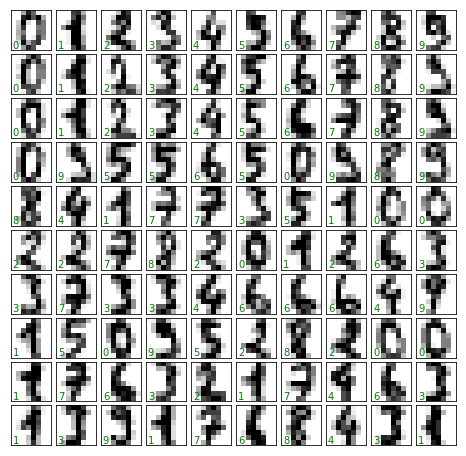

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

Para trabajar con estos datos dentro de Scikit-Learn, necesitamos una representación bidimensional, `` [n_samples, n_features] ``. Podemos lograr esto tratando cada píxel de la imagen como una característica, es decir, "aplanando" las matrices de píxels de manera tal de tener una matriz de valores de pixels de longitud 64 que representa cada dígito. 
Además, necesitamos el vector objetivo, que proporciona la etiqueta previamente determinada para cada dígito.
Estas dos cantidades, como es usual, ya están directamente disponibles en el conjunto de datos ``digits`` bajo las claves ``data`` y ``target``, respectivamente:

In [7]:
X = digits.data
X.shape

(1797, 64)

In [8]:
y = digits.target
y.shape

(1797,)

Podemos ver que hay 1,797 muestras y 64 features.

In [9]:
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [10]:
digits.data[0].shape

(64,)

In [11]:
digits.target[0]

0

### Aprendizaje no supervisado: reducción de dimensionalidad

Sería bueno poder visualizar nuestros puntos de datos dentro de un espacio de 64 dimensiones, pero es difícil visualizar efectivamente los puntos en un espacio de tan alta dimensión.
En su lugar, reduciremos las dimensiones a 2, utilizando un método no supervisado.
Aquí, haremos uso de un algoritmo de aprendizaje llamado *Isomap*, y transformaremos los datos en dos dimensiones:

In [12]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

Podemos ver que los datos proyectados ahora son bi-dimensionales. Como se dijo previamente, la tarea de reducción de dimensionalidad es determinar si existe una representación adecuada con menos dimensiones que conserve las características esenciales de los datos. Otro aspecto interesante a resaltar es que este proceso es completamente no supervisado (no toma en cuenta el vector destino con las clases)
Grafiquemos dichos datos para ver si podemos aprender alguna cosa a partir de su estructura:

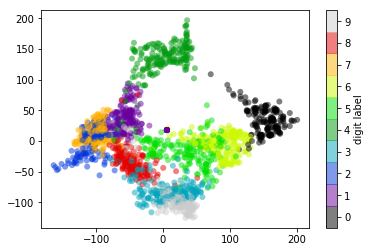

In [13]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

Esta figura nos da una buena idea intuitiva de cuan bien se separan los distintos números en el espacio más grande de 64 dimensiones. Por ejemplo, los ceros (en negro) y y los unos (en violeta) tienen muy poca superposición en el espacio de parámetros. Intuitivamente, esto tiene sentido: un cero está vacío en el medio de la imagen, mientras que un uno generalmente tendrá tinta en el medio. Por otro lado, parece haber un espectro más o menos continuo entre los unos y los cuatro: podemos entender esto al darnos cuenta de que algunas personas dibujan los unos con "sombreros", lo que hace que se vean de forma similar a los cuatros.

En general, sin embargo, los diferentes grupos parecen estar bastante bien separados en el espacio de parámetros: esto nos dice que incluso un algoritmo de clasificación supervisado muy sencillo debería funcionar adecuadamente en estos datos. Hagamos el intento!.

### Clasificación sobre los dígitos

Apliquemos un algoritmo de clasificación a los dígitos. Al igual que con los datos de Iris analizados previamente, dividiremos los datos en un conjunto de entrenamiento y uno de prueba. Luego aprenderemos un modelo ingenuo de Bayes gaussiano:

In [14]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [15]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

Con las predicciones de nuestro modelo, podemos ahora medir su precisión comparando los valores verdaderos del conjunto de prueba con estas predicciones:

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

0.8333333333333334

Como podemos observar, incluso con este modelo extremadamente simple, obtenemos aproximadamente un 80% de precisión para la clasificación de los dígitos!! 
Sin embargo, este número único no nos dice nada sobre dónde nos hemos equivocado: como sabemos, una buena forma de hacerlo es usando la matriz de confusión, que podemos calcular con Scikit-Learn y graficar con Seaborn:

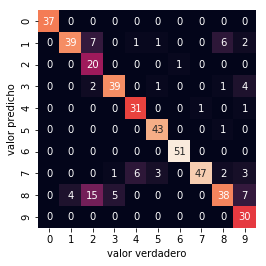

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, y_model)

sns.heatmap(mat.T, square=True, annot=True, cbar=False)
plt.xlabel('valor verdadero')
plt.ylabel('valor predicho');

Esto nos muestra dónde tienden a estar los puntos mal etiquetados: por ejemplo, un gran número de dos aquí se clasifican erróneamente como unos u ochos. 
Otra forma de ganar intuición en las características del modelo es graficar las entradas nuevamente, con las etiquetas predichas. Usaremos verde para las etiquetas correctas, y rojo para las etiquetas incorrectas:


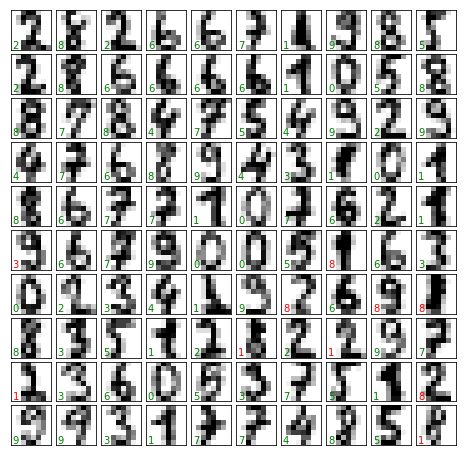

In [18]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(y_model[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == y_model[i]) else 'red')

Examinando este subconjunto de los datos, podemos obtener información sobre dónde el algoritmo podría no funcionar de manera óptima.
Para ir más allá de nuestra tasa de clasificación del 80%, podríamos pasar a un algoritmo más sofisticado, como las máquinas de vectores de soporte (SVM), random forest u otro enfoque de clasificación.